In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timedelta
import numpy.random as random
import numpy as np
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [3]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_convert('Australia/Sydney')
strava.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-03 07:47:51+11:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 12:36:53+11:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 13:56:00+11:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 16:37:04+11:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-06 06:22:46+11:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [4]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


Once you have read the two datasets into the corresponding dataframes, the next step is checking the size of the initial datasets. 
The dataset derived from strava contains 268 records and 10 colums, while the dataset from cheetah has 251 observations and 362 colums.

In [10]:
print('Strava dataset contains',strava.shape[0],'rows and',strava.shape[1],'columns')
print('Cheetah dataset contains',cheetah.shape[0],'rows and',cheetah.shape[1],'columns')

Strava dataset contains 268 rows and 10 columns
Cheetah dataset contains 251 rows and 362 columns


The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:



## Required Analysis

1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 
* Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
* We want to explore the differences between the three categories: `Race`, `Workout` and `Ride`.
    * Use scatter plots with different colours for each category to explore how these categories differ.  
    * Use histograms or box plots to visualise the different distributions of a variable for the three categories.
    * In both cases, experiment with different variables but only include those that are interesting in your final notebook (if none are interesting, show us a representative example).


## Challenge

* What leads to more `kudos`? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe. 

* Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.

* Generate a similar graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

Hint: to generate these summary plots you need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  

__Note:__ once you have completed these steps you can remove this cell.  Use the text as a starting point for the documentation of your workflow and discussion of results.


## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [47]:
#strava containts 268 records and 10 columns
#cheetah contains 251 observations and 362 columns
cd=cheetah.join(strava,how='inner')
cd.shape

#The Combined_Data has 243 rows and 372 columns

(243, 372)

In [48]:
#Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
drop_indexes=cd[cd['device_watts']==False].index
cd.drop(drop_indexes,inplace=True)
cd.shape
#34 rows have been found and deleted
#209 rows left and 372 variables in total
#cd['distance']


(209, 372)

Maybe here you can write down properly the status of you new dataset

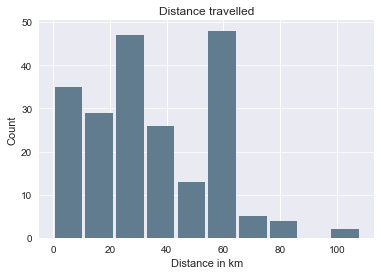

In [49]:
#Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed?
#DISTANCE
cd['distance'].plot.hist(grid=True,color='#607c8e',rwidth=0.9)
plt.title('Distance travelled')
plt.xlabel('Distance in km')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

The distribution looks right skewed which means that the majority of distances are in the shortest distances

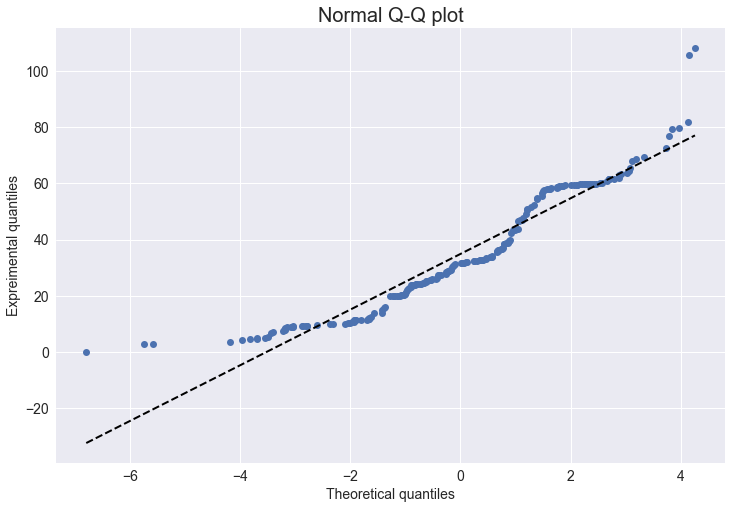

In [50]:

cd.sort_values(by='Distance',ascending= True,inplace=True)
norm=random.normal(0,2,len(cd['Distance']))
norm.sort()
plt.figure(figsize=(12,8),facecolor='1.0') 

plt.plot(norm,cd['Distance'],"o")

#generate a trend line
z = np.polyfit(norm,cd['Distance'], 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=20)
plt.xlabel("Theoretical quantiles", size=14)
plt.ylabel("Expreimental quantiles", size=14)
plt.tick_params(labelsize=14)
plt.show()

The line does not seem straight therefore we can say that distance in not normally distributed


In [51]:
#Please return to the original order of distances
cd['Distance'].sort_index(axis=0, ascending=True, inplace=True)

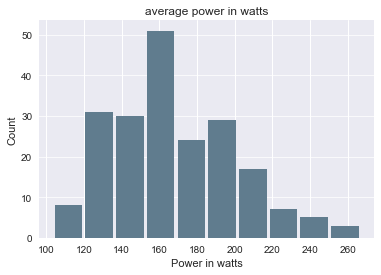

In [52]:
#average_watts
#cd['average_watts'].head()
cd['average_watts'].plot.hist(color='#607c8e',rwidth=0.9)
plt.title('average power in watts')
plt.xlabel('Power in watts')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

Look at histograms at pag 36

The average power look fairly normally distributed.

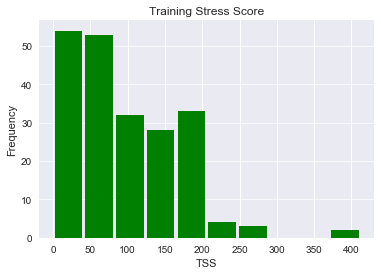

In [62]:
cd['TSS'].plot.hist(color='g',rwidth=0.9)
plt.title('Training Stress Score')
plt.xlabel('TSS')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)


In [63]:
#Please return to the original order of distances
cd['TSS'].sort_index(axis=0, ascending=True, inplace=True)

Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?
    * Distance ->Distance
    * Moving Time -> moving_time
    * Average Speed ?
    * Heart Rate->average_heartrate
    * Power (watts)->average_watts
    * Normalised power (NP)-> NP
    * Training Stress Score-> TSS
    * Elevation Gain->elevation_gain

In [72]:
cd_exp=cd[['Distance','moving_time','average_heartrate','average_watts','NP','TSS','elevation_gain']]
corr = cd_exp.corr()

In [73]:
#comment on this better
#corr[average_heartrate,average_watts]=0.672457
#corr[NP,average_watts]=0.772574

,Distance,moving_time,average_heartrate,average_watts,NP,TSS
Distance,1.000000,-0.076118,0.062746,0.094800,0.004340,-0.051670
moving_time,-0.076118,1.000000,-0.048611,-0.112507,0.044431,0.056732
average_heartrate,0.062746,-0.048611,1.000000,0.672457,0.593091,0.012311
average_watts,0.094800,-0.112507,0.672457,1.000000,0.772574,-0.073171
NP,0.004340,0.044431,0.593091,0.772574,1.000000,0.000438
TSS,-0.051670,0.056732,0.012311,-0.073171,0.000438,1.000000


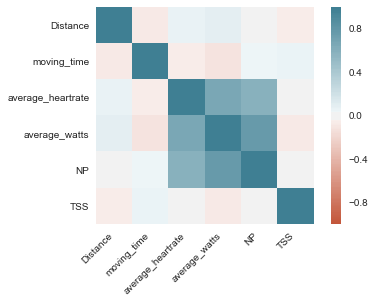

In [76]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a27823b38>,
      dtype=object)

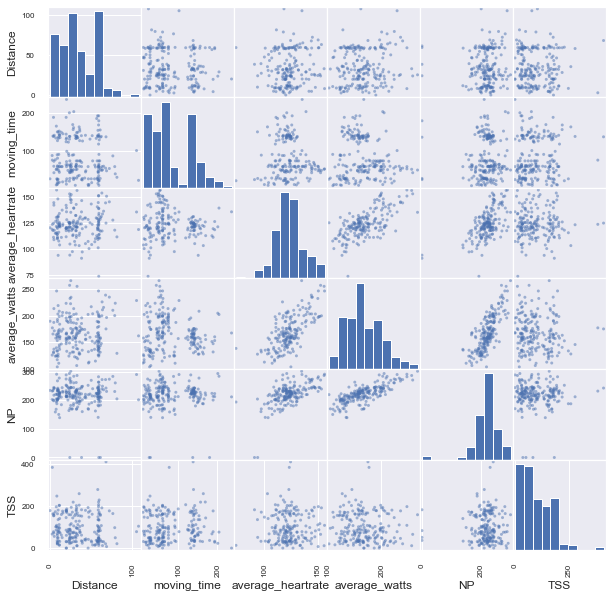

In [84]:
from pandas.plotting import scatter_matrix
scatter_matrix(cd_exp, alpha = 0.5, figsize = (10, 10), diagonal = 'hist')

ValueError: Could not interpret input 'calories'

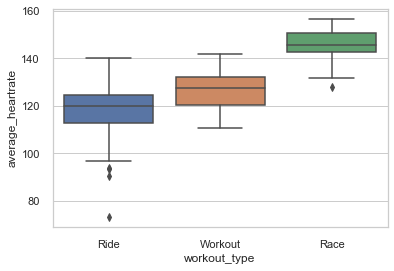

In [98]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="workout_type", y="average_heartrate", data=cd)


What is the distribution of this categorical data!pag 33

Seems like that the average_hearthrate is higher when you race comparing other workout type